Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [104]:
NAME = "Piotr Szuba"

---

# 2. Wielomodalne autokodery

Przejdziemy teraz do implementacji modelu **wielomodalnego autokodera**. W przypadku rozważanych przez nas danych, autokoder ten będzie posiadać dwa wejścia oraz dwa wyjścia (wcześniej wyznaczone wektory cech obrazków oraz tekstów).

In [105]:
from typing import Dict, List, Type

import pandas as pd
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import functional as F

from src.dataset import DataModule
from src.downstream import evaluate_classification
from src.nn.unimodal import UnimodalAE
from src.train import extract_embeddings, train_model
from src.visualization import make_interactive_scatter_plot, visualize_most_similar


class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, last_activation):
        super().__init__()

        self.mlp = self._create_mlp(in_dim, hidden_dims, out_dim, last_activation)

    def _create_mlp(self, in_dim, hidden_dims, out_dim, last_activation):
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], out_dim))
        layers.append(last_activation())
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

## Zadanie 2.1 (2 pkt)
Zaczniemy od implementacji modułu kodera wielomodalnego. Należy uzupełnić poniższą implementację w taki sposób, aby:
- dla każdej modalności (określonej przez parametr `modality_names`) został utworzony modal perceptrona wielowarstwowego (MLP), który będzie przekształcać cechy w danej modalności (pamiętaj aby odpowiednio przypisać moduły PyTorchowe – np. `ModuleList` albo `ModuleDict`)
- MLP dla każdej modalności będzie posiadać taką samą architekturę (z wyłączeniem wymiaru wejściwego) - wykorzystaj podane w konstruktorze parametry dla tych sieci MLP:
  * `in_dims` - wymiary danych wejściowych dla każdej modalności,
  * `hidden_dims` - rozmiary warstw ukrytych, takie same dla każdego MLP,
  * `out_dim` - wyjściowy rozmiar, również takie same dla każdego MLP.
- w metodzie `forward()` przekształć odpowiednie modalności przez przypisane do nich sieci MLP, na wyjściu zwróć listę wektorów

In [106]:
import torch
from torch import nn
from typing import Dict, List, Type

class MultimodalEncoder(nn.Module):
    def __init__(
        self,
        modality_names: List[str],
        in_dims: Dict[str, int],
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        self.modality_names = modality_names

        self.modal_encoders = nn.ModuleDict({
            name: MLP(in_dim, hidden_dims, out_dim, last_activation)
            for name, in_dim in in_dims.items()
        })

    def forward(self, x: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        return [self.modal_encoders[name](x[name]) for name in self.modality_names]

    @staticmethod
    def from_hparams(hparams):
        return MultimodalEncoder(
            modality_names=hparams["modality_names"],
            in_dims=hparams["data_dims"],
            hidden_dims=hparams["hidden_dims"],
            out_dim=hparams["emb_dim"],
            last_activation=nn.Tanh,
        )

## Zadanie 2.2 (2 pkt)
Zaimplementuj dwie strategie łączenia wektorów ukrytych z różnych modalności w jeden wielomodalny wektor reprezentacji:
- w klasie `AvgFusion` zaimplementuj uśrednianie wektorów z różnych modalności
- w klasie `MLPFusion` skonkatenuj wektory z różnych modalności a następnie przekształć wynik przez sieć MLP (parametry sieci podane w konstruktorze)

In [107]:
class AvgFusion(nn.Module):
    
    def forward(self, h: List[torch.Tensor]) -> torch.Tensor:
        return torch.mean(torch.stack(h), dim=0)
    
    
class MLPFusion(nn.Module):
    
    def __init__(
        self,
        modality_dim: int,
        num_modalities: int,
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        in_dim = modality_dim * num_modalities
        self.mlp = MLP(in_dim, hidden_dims, out_dim, last_activation)

    def forward(self, h: List[torch.Tensor]) -> torch.Tensor:
        concatenated = torch.cat(h, dim=1)
        return self.mlp(concatenated)

## Zadanie 2.3 (2 pkt)
Analogicznie do kodera wielomodalnego, musimy zaimplementować moduł wielomodalnego dekodera.
- dla każdej modalności utwórz sieć MLP, która będzie dekodować (rekonstruować) oryginalne atrybuty obiektu w danej modalności:
  * `in_dim` określa wymiar wejściowego wielomodalnego wektora reprezentacji (wspólne dla wszystkich modalności)
  * `hidden_dims` określa rozmiary warstw ukrytych modeli MLP (wspólne dla wszystkich modalności)
  * `out_dims` określa wymiary atrybutów (które chcemy zrekonstruować) w każdej modalności
- w metodzie `forward()` zastosuj utworzone sieci MLP na wielomodalnej reprezentacji `z` i zwróć słownik, w którym klucze określają nazwy modalności a skojarzone wartości to rekonstrukcje atrybutów w danej modalności

In [108]:
class MultimodalDecoder(nn.Module):
    def __init__(
        self,
        modality_names: List[str],
        in_dim: int,
        hidden_dims: List[int],
        out_dims: Dict[str, int],
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        self.modality_names = modality_names

        self.modal_decoders = nn.ModuleDict({
            name: MLP(in_dim, hidden_dims, out_dim, last_activation)
            for name, out_dim in out_dims.items()
        })

    def forward(self, z: torch.Tensor) -> Dict[str, torch.Tensor]:
        return {name: self.modal_decoders[name](z) for name in self.modality_names}

## Zadanie 2.4 (2 pkt)
Przeanalizuj implementację klasy bazowej `BaseAE` a następnie dokończ implementację właściwego wielomodalnego autokodera:
- w metodzie `forward()` zastosuj wielomodalny koder `encoder` na podanych danych wejściowych, a następnie połącz listę ukrytych wektorów w jedną wielomodalną reprezentację, wykorzystując moduł fuzji `fusion`
- w metodzie `_common_step()` zaimplementuj krok uczenia autokodera:
  * wyznacz wielomodalną reprezentację `z`
  * przeprowadź rekonstrukcję oryginalnych cech `x_rec` na podstawie reprezentacji `z`
  * oblicz funkcję kosztu jako błąd średniokwadratowy (`MSE`) po każdej modalności, a wartości tych funkcji kosztu uśrednij względem wszystkich modalności

In [109]:
from src.nn.ae import BaseAE


class MultimodalAE(BaseAE):

    def __init__(self, hparams):
        encoder_cls = hparams["encoder_cls"]
        
        super().__init__(
            hparams=hparams,
            encoder=encoder_cls.from_hparams(hparams),
            decoder=MultimodalDecoder(
                modality_names=hparams["modality_names"],
                in_dim=hparams["emb_dim"],
                hidden_dims=hparams["hidden_dims"][::-1],
                out_dims=hparams["data_dims"],
                last_activation=nn.Identity,
            ),
        )
        
        if hparams["fusion"] == "Avg":
            self.fusion = AvgFusion()
        elif hparams["fusion"] == "MLP":
            self.fusion = MLPFusion(
                modality_dim=hparams["emb_dim"],
                num_modalities=len(hparams["modality_names"]),
                hidden_dims=[hparams["emb_dim"], hparams["emb_dim"]],
                out_dim=hparams["emb_dim"],
                last_activation=nn.Tanh,
            )
        else:
            raise ValueError(f"Unknown fusion module: \"{hparams['fusion']}\"")
    
    def forward(self, batch) -> torch.Tensor:
        h = self.encoder(batch)
        z = self.fusion(h)

        return z

    def _common_step(self, batch) -> torch.Tensor:
        z = self.forward(batch)
        x_rec = self.decoder(z)

        loss = 0
        for modality in self.hparams["modality_names"]:
            loss += F.mse_loss(x_rec[modality], batch[modality])
        loss /= len(self.hparams["modality_names"])

        return loss

In [110]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23372), started 1:46:51 ago. (Use '!kill 23372' to kill it.)

In [111]:
default_hparams = {
    "encoder_cls": MultimodalEncoder,
    "modality_names": ["img_emb", "text_emb"],
    "data_dims": {"img_emb": 2048, "text_emb": 384}, 
    "batch_size": 64,
    "num_epochs": 30,
    "hidden_dims": [256, 256, 256],
    "emb_dim": 128,
    "lr": 1e-3,
    "weight_decay": 5e-4,
}

In [112]:
datamodule = DataModule(batch_size=default_hparams["batch_size"])

In [113]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "ImageTextAvgAE",
        "fusion": "Avg",
        **default_hparams,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

c:\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning:

Checkpoint directory C:\Users\Piotr Szuba\Desktop\Semestr 1\UczenieReprezentacji\Lab6\data\checkpoints\ImageTextAvgAE exists and is not empty.


  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params siz

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [114]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "ImageTextMLPAE",
        "fusion": "MLP",
        **default_hparams,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning:

Checkpoint directory C:\Users\Piotr Szuba\Desktop\Semestr 1\UczenieReprezentacji\Lab6\data\checkpoints\ImageTextMLPAE exists and is not empty.


  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | MLPFusion         | 65.9 K
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.889     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [115]:
multimodal_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="ImageTextAvgAE",
    datamodule=datamodule,
)

multimodal_mlp_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="ImageTextMLPAE",
    datamodule=datamodule,
)


In [116]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(multimodal_avg_emb),
    df=datamodule.df["all"],
    port=8052
)

Dash is running on http://127.0.0.1:8052/



In [117]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (MLP)",
    z_2d=PCA(n_components=2).fit_transform(multimodal_mlp_emb),
    df=datamodule.df["all"],
    port=8053,
)

Dash is running on http://127.0.0.1:8053/



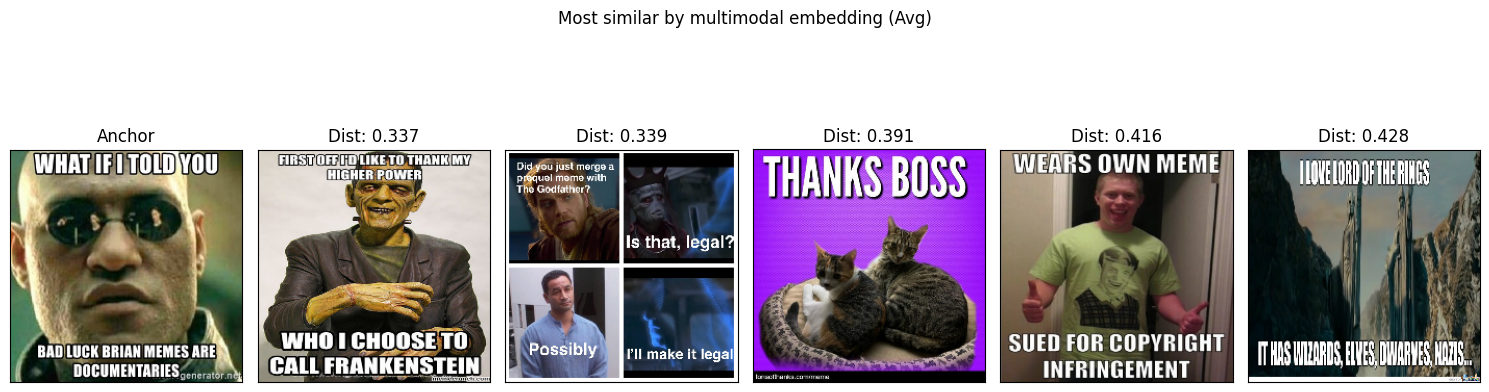

In [118]:
_ = visualize_most_similar(
    title="Most similar by multimodal embedding (Avg)",
    anchor_index=339,
    z=multimodal_avg_emb,
    df=datamodule.df["all"],
)

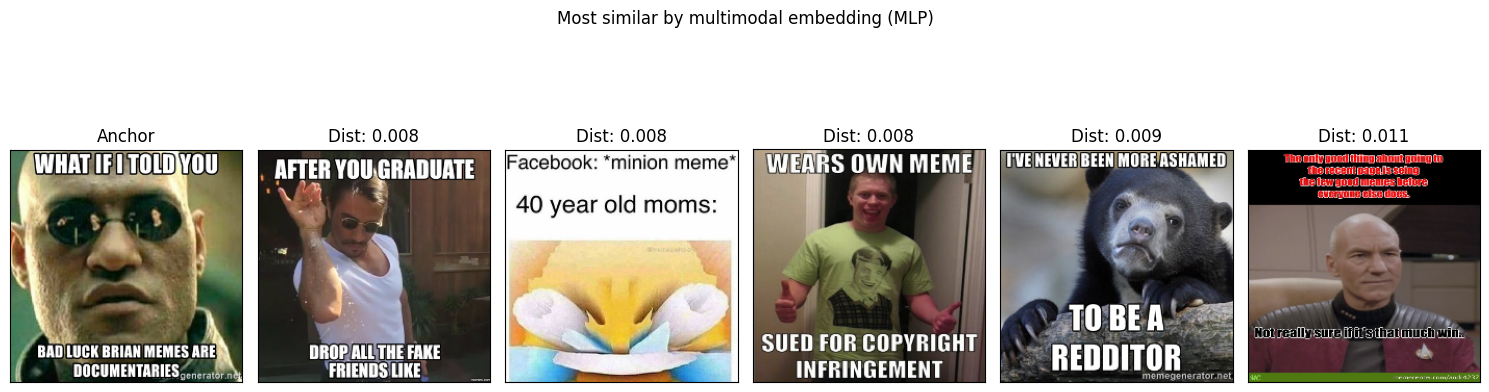

In [119]:
_ = visualize_most_similar(
    title="Most similar by multimodal embedding (MLP)",
    anchor_index=339,
    z=multimodal_mlp_emb,
    df=datamodule.df["all"],
)

In [120]:
evaluate_classification(
    model_names=[
        (UnimodalAE, "ImageAE"), 
        (UnimodalAE, "TextAE"), 
        (MultimodalAE, "ImageTextAvgAE"),
        (MultimodalAE, "ImageTextMLPAE"),
    ],
    datamodule=datamodule,
)

train_AUC                                                 
task               humour motivational  offensive    sarcasm  sentiment   
model                                                                     
ImageAE         56.41 [%]    55.66 [%]  53.66 [%]  56.28 [%]  55.46 [%]  \
TextAE          60.41 [%]    57.32 [%]  61.89 [%]  62.82 [%]  61.59 [%]   
ImageTextAvgAE  56.99 [%]    57.24 [%]  59.28 [%]  60.17 [%]  60.00 [%]   
ImageTextMLPAE  52.48 [%]    53.32 [%]  54.25 [%]  52.26 [%]  52.70 [%]   

                 test_AUC                                                
task               humour motivational  offensive    sarcasm  sentiment  
model                                                                    
ImageAE         50.39 [%]    50.93 [%]  50.41 [%]  49.09 [%]  48.00 [%]  
TextAE          50.59 [%]    45.30 [%]  54.52 [%]  52.65 [%]  46.18 [%]  
ImageTextAvgAE  51.05 [%]    49.09 [%]  53.82 [%]  52.11 [%]  49.71 [%]  
ImageTextMLPAE  51.63 [%]    49.79 [%]  50.32 [%]  55.03 [%]  45.72 [%]

# Maskowane uczenie
Dotychczas wielomodalny autokoder był uczony w taki sposób, że zarówno na wejściu jak i na wyjściu otrzymywał informacje o obrazku, jak i tekście. Teraz zobaczymy jak model się będzie zachowywać w sytuacji, kiedy jedna z modalności będzie **maskowana na wejściu** (można w ten sposób symulować sytuacje, gdy jedna z modalności nie jest dostępna – *brakująca wartość*). 

Zaczniemy od przygotowania nowej implementacji `MultimodalEncoder`.

## Zadanie 2.5 (2 pkt)
Uzupełnij poniższą implementację klasy `MaskedMultimodalEncoder`, która będzie maskować cechy z wybranej modalności z określonym prawdopodobieństwem `p_m`:

- poprzez maskowanie danej modalności rozumiemy zastąpienie wektora cech w tej modalności dla konkretnego obiektu, wektorem składającym się z samych zer
- to czy pojedynczy obiekt będzie poddawany maskowaniu określamy na podstawie prawdopodobieństwa $p_m \in [0, 1]$
- zakładamy, że maskowanie dotyczy tylko etapu uczenia, natomiast w trakcie inferencji używamy dostępnych cech bez jakiejkolwiek modyfikacji

In [121]:
class MaskedMultimodalEncoder(nn.Module):
    def __init__(
        self,
        modality_names: List[str],
        in_dims: Dict[str, int],
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
        masked_modality: str,
        p_m: float,
        training: bool = True
    ):
        super().__init__()

        self.modality_names = modality_names
        self.masked_modality = masked_modality
        self.p_m = p_m
        self.training = training

        self.modal_encoders = nn.ModuleDict({
            name: MLP(in_dim, hidden_dims, out_dim, last_activation)
            for name, in_dim in in_dims.items()
        })

    def forward(self, x: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        if self.training:
            x_copy = x.copy()
            for name in self.modality_names:
                if name == self.masked_modality:
                    mask = torch.bernoulli(torch.full(x[name].shape, 1 - self.p_m)).bool()
                    x_copy[name] = x[name] * mask.to(x[name].device)
            return [self.modal_encoders[name](x_copy[name]) for name in self.modality_names]
        else:
            return [self.modal_encoders[name](x[name]) for name in self.modality_names]

    @staticmethod
    def from_hparams(hparams):
        return MaskedMultimodalEncoder(
            modality_names=hparams["modality_names"],
            in_dims=hparams["data_dims"],
            hidden_dims=hparams["hidden_dims"],
            out_dim=hparams["emb_dim"],
            last_activation=nn.Tanh,
            masked_modality=hparams["masked_modality"],
            p_m=hparams["p_m"],
        )

In [122]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedImage_ImageTextAvgAE",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": 1.0,
    },
    datamodule=datamodule,
)

train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedText_ImageTextAvgAE",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "text_emb",
        "p_m": 1.0,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.


  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [123]:
masked_image_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="MaskedImage_ImageTextAvgAE",
    datamodule=datamodule,
)

masked_text_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="MaskedText_ImageTextAvgAE",
    datamodule=datamodule,
)


In [124]:
make_interactive_scatter_plot(
    title="Masked Image (p_m = 1.0) - Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(masked_image_avg_emb),
    df=datamodule.df["all"],
    port=8054
)

Dash is running on http://127.0.0.1:8054/



In [125]:
make_interactive_scatter_plot(
    title="Masked Text (p_m = 1.0) - Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(masked_text_avg_emb),
    df=datamodule.df["all"],
    port=8055
)

Dash is running on http://127.0.0.1:8055/



In [126]:
evaluate_classification(
    model_names=[
        (UnimodalAE, "ImageAE"), 
        (UnimodalAE, "TextAE"), 
        (MultimodalAE, "ImageTextAvgAE"),
        (MultimodalAE, "ImageTextMLPAE"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE"),
    ],
    datamodule=datamodule,
)

train_AUC                                      
task                           humour motivational  offensive    sarcasm   
model                                                                      
ImageAE                     56.41 [%]    55.66 [%]  53.66 [%]  56.28 [%]  \
TextAE                      60.41 [%]    57.32 [%]  61.89 [%]  62.82 [%]   
ImageTextAvgAE              56.99 [%]    57.24 [%]  59.28 [%]  60.17 [%]   
ImageTextMLPAE              52.48 [%]    53.32 [%]  54.25 [%]  52.26 [%]   
MaskedImage_ImageTextAvgAE  56.21 [%]    57.71 [%]  58.91 [%]  60.32 [%]   
MaskedText_ImageTextAvgAE   64.34 [%]    63.45 [%]  69.14 [%]  62.72 [%]   

                                        test_AUC                           
task                        sentiment     humour motivational  offensive   
model                                                                      
ImageAE                     55.46 [%]  50.39 [%]    50.93 [%]  50.41 [%]  \
TextAE                      61.59 [%]  50.59 [%]    45.30 [%]  54.52 [%]   
ImageTextAvgAE              60.00 [%]  51.05 [%]    49.09 [%]  53.82 [%]   
ImageTextMLPAE              52.70 [%]  51.63 [%]    49.79 [%]  50.32 [%]   
MaskedImage_ImageTextAvgAE  60.11 [%]  50.02 [%]    47.94 [%]  56.41 [%]   
MaskedText_ImageTextAvgAE   65.36 [%]  47.36 [%]    47.87 [%]  49.80 [%]   

                                                  
task                          sarcasm  sentiment  
model                                             
ImageAE                     49.09 [%]  48.00 [%]  
TextAE                      52.65 [%]  46.18 [%]  
ImageTextAvgAE              52.11 [%]  49.71 [%]  
ImageTextMLPAE              55.03 [%]  45.72 [%]  
MaskedImage_ImageTextAvgAE  51.81 [%]  49.61 [%]  
MaskedText_ImageTextAvgAE   53.34 [%]  46.45 [%]

## Zadanie 2.6 (2 pkt)
Zbadaj jak wartość parametru `p_m` wpływa na jakość otrzymywanych multimodalnych wektorów reprezentacji? (Skrajne wartości `p_m = 0` oraz `p_m = 1` zbadaliśmy w poprzednich przykładach). Skomentuj otrzymane wyniki.

In [127]:
def check_masking_probability_performance():
    # TU WPISZ KOD
    raise NotImplementedError()